In [1]:
def _hotfix10447_monkey():
    import energyplus.core
    DataExchange = energyplus.core.pyenergyplus.datatransfer.DataExchange

    if getattr(DataExchange, '_hotfix10447', False):
        return
    
    _get_api_data = DataExchange.get_api_data
    def _hotfix10447_get_api_data(self, state):
        return [
            DataExchange.APIDataExchangePoint(
                _what=datapoint.what,
                _name=datapoint.name, 
                _key=datapoint.type, 
                _type=datapoint.key,
            )
            for datapoint in (
                _get_api_data(self, state)
            )
        ]
    DataExchange.get_api_data = _hotfix10447_get_api_data
    setattr(DataExchange, '_hotfix10447', True)

_hotfix10447_monkey()

In [2]:
#%pip install 'git+https://github.com/ray-project/ray/#&subdirectory=rllib_contrib/td3' --ignore-requires-python

In [1]:
%pip install -U ../../EnergyPlus-OOEP

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Processing /home/AD/user/lab/EnergyPlus-OOEP
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for controllables-core: filename=controllables_core-0.0.post1.dev27+g51c68c4.d20241025-py3-none-any.whl size=55909 sha256=3306a68dea21f338dea5c223bd002215e066ad28260a32b9717e9d2a71e85f62
  Stored in directory: /home/AD/user/.cache/pip/wheels/29/a1/aa/463af4dfcc711a0e44b3bf3e9b714e17a8f0ee0a753fcf5980
Successfully built controllables-core
  Attempting uninstall: controllables-core
    Found existing installation: controllables-core 0.0.post1.dev27+g51c68c4.d20241019
    Uninstalling controllables-core-0.0.post1.dev27+g51c68c4.d20241019:
      Successfully uninstalled controllables-core-0.0.post1.dev27+g51c68c4.d20241019

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

In [1]:
import energyplus.ooep as _ooep_
from energyplus.dataset.basic import dataset as _epds_

simulator = _ooep_.World(
    input=_ooep_.World.Specs.Input(
        world='data/model-current.idf',
        #world='tmp_timestep 10 min.idf',
        weather='SGP_Singapore_486980_IWEC.epw',
    ),
    output=_ooep_.World.Specs.Output(
        report='./tmp',
    ),
    runtime=_ooep_.World.Specs.Runtime(
        recurring=True,
        #design_day=True,
    ),
)

from energyplus.ooep.addons.logging import ProgressLogger

# add progress provider
_ = simulator.add(ProgressLogger())

  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
_ = simulator.awaitable.run()


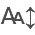

type                     control_type  \
0             Schedule:Compact                               ON   
1             Schedule:Compact                              OFF   
2             Schedule:Compact                  WORK EFFICIENCY   
3             Schedule:Compact                      OPAQUESHADE   
4             Schedule:Compact  ZONE COMFORT CONTROL TYPE SCHED   
...                        ...                              ...   
2301  Zone Temperature Control     0FGROUNDFLOOREAST:OPENOFFICE   
2302  Zone Temperature Control      CORECIRCULATION:CIRCULATION   
2303  Zone Temperature Control      CORECIRCULATION:CIRCULATION   
2304  Zone Temperature Control        ATRIUMRECEPTION:RECEPTION   
2305  Zone Temperature Control        ATRIUMRECEPTION:RECEPTION   

                   key  
0       Schedule Value  
1       Schedule Value  
2       Schedule Value  
3       Schedule Value  
4       Schedule Value  
...                ...  
2301  Cooling Setpoint  
2302  Heating Setpoint  
2303  Cooling Setpoint  
2304  Heating Setpoint  
2305  Cooling Setpoint  

[2306 rows x 3 columns]

In [3]:
#check actuator and OutputVariable
list(simulator.variables.available_keys().group(type).keys())

# TODO mv
import pandas as _pandas_
import itables as _itables_
_itables_.init_notebook_mode(all_interactive=True)

_pandas_.DataFrame(simulator.variables.available_keys().group(type)[_ooep_.Actuator.Ref])
# list(simulator.variables.available_keys().group(type)[_ooep_.OutputVariable.Ref])
# _pandas_.DataFrame(simulator.variables.available_keys().group(type)[_ooep_.OutputMeter.Ref])
# list(
#     simulator.variables.available_keys().group(type)[_ooep_.Actuator.Ref].group(lambda x: x.type).keys()
# )

In [7]:
for a in simulator._core.api.exchange.get_api_data(simulator._core.state):
    if a.what == 'OutputMeter':
        print([a.what, a.name, a.key, a.type])

['OutputMeter', '', 'Electricity:Facility', '']
['OutputMeter', '', 'Electricity:Building', '']
['OutputMeter', '', 'Electricity:Zone:1FFIRSTFLOOREAST:OPENOFFICE', '']
['OutputMeter', '', 'Electricity:SpaceType:GENERAL', '']
['OutputMeter', '', 'InteriorLights:Electricity', '']
['OutputMeter', '', 'InteriorLights:Electricity:Zone:1FFIRSTFLOOREAST:OPENOFFICE', '']
['OutputMeter', '', 'InteriorLights:Electricity:SpaceType:GENERAL', '']
['OutputMeter', '', 'ELECTRIC EQUIPMENT#1FFirstFloorEast:OpenOffice#GeneralLights:InteriorLights:Electricity', '']
['OutputMeter', '', 'ELECTRIC EQUIPMENT#1FFirstFloorEast:OpenOffice#GeneralLights:InteriorLights:Electricity:Zone:1FFIRSTFLOOREAST:OPENOFFICE', '']
['OutputMeter', '', 'ELECTRIC EQUIPMENT#1FFirstFloorEast:OpenOffice#GeneralLights:InteriorLights:Electricity:SpaceType:GENERAL', '']
['OutputMeter', '', 'Electricity:Zone:1FFIRSTFLOORWEST:OPENOFFICE', '']
['OutputMeter', '', 'InteriorLights:Electricity:Zone:1FFIRSTFLOORWEST:OPENOFFICE', '']
['Outpu

In [8]:
from numpy import array, float32
params = {'tdb': array(30.156845, dtype=float32), 'tr': array(30.7969, dtype=float32), 'vr': array(0.25), 'rh': array(45.02162, dtype=float32), 'met': array(1.5), 'clo': array(0.433)}
#params = {'tdb': 29.990000000156845, 'tr': 28.7969, 'vr': .25, 'rh': 70.02162, 'met': 1.5, 'clo': 0.433}

import pythermalcomfort as pytc

pytc.models.pmv_ppd(**params, limit_inputs=False)

{'pmv': 1.67, 'ppd': 60.3}

In [9]:
#%pip install --upgrade ray[rllib]==2.5.1

In [1]:
import numpy as _numpy_
import gymnasium as _gymnasium_
import pandas as pd
import os

from controllables.core.tools.rl import (
    VariableBox,
    ExternalEnv,
)

import ray
from ray import tune , air
from ray.tune.schedulers import PopulationBasedTraining

from controllables.energyplus import (
    World,
    Actuator,
    OutputVariable,
)
import pythermalcomfort as pytc
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.sac import SACConfig

from ray.rllib.algorithms.callbacks import DefaultCallbacks

import logging
import csv
import math

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', filename='training.log')

class CustomExternalEnv(ExternalEnv):
    def __init__(self, env_config):
        pass

    def step(self, action):
        pass

class RewardFunction:
    def __init__(self, metab_rate=1.5, clothing=.5, pmv_limit=.5):
        self._metab_rate = _numpy_.asarray(metab_rate)
        self._clothing = _numpy_.asarray(clothing)
        self._pmv_limit = _numpy_.asarray(pmv_limit)
    
   
    def __call__(self, agent):
        observation = agent.observation.value     
        AHU_COOLING_COIL = observation['AHU COOLING COIL']
        Fan_Electricity_Rate = observation['Fan Electricity Rate']
        Office_Occupancy = observation['Office Occupancy']
        pmv = pytc.models.pmv_ppd(
            tdb=(tdb := observation['temperature:drybulb']), 
            tr=observation['temperature:radiant'], 
            # calculate relative air speed
            vr=pytc.utilities.v_relative(v=observation.get('airspeed', .1), met=self._metab_rate), 
            rh=observation['humidity'], 
            met=self._metab_rate, 
            # calculate dynamic clothing
            clo=pytc.utilities.clo_dynamic(clo=self._clothing, met=self._metab_rate),
            limit_inputs=False ,
        )['pmv']
        
        reward = (
            2*Office_Occupancy*((self._pmv_limit - _numpy_.abs(pmv)) / self._pmv_limit) - (AHU_COOLING_COIL/180000) 
            - (Fan_Electricity_Rate/6200)
        )
        inputs = {'AHU_energy': AHU_COOLING_COIL, 'tdb': observation['temperature:drybulb'],
                'tr': observation['temperature:radiant'], 
                'vr': pytc.utilities.v_relative(v=observation.get('airspeed', .1), met=self._metab_rate), 
                'rh': observation['humidity'], 'met': self._metab_rate,
                'clo': pytc.utilities.clo_dynamic(clo=self._clothing, met=self._metab_rate),
                'pmv':pmv ,
                'reward':reward}
        for name, value in inputs.items():
            if math.isnan(value):
                print(f"NaN detected in input: {name}")
                print(dict(
                    tdb=(observation['temperature:drybulb']), 
                    tr=observation['temperature:radiant'], 
                    # calculate relative air speed
                    vr=pytc.utilities.v_relative(v=observation.get('airspeed', .1), met=self._metab_rate), 
                    rh=observation['humidity'], 
                    met=self._metab_rate, 
                    # calculate dynamic clothing
                    clo=pytc.utilities.clo_dynamic(clo=self._clothing, met=self._metab_rate),
                ))
                raise Exception('TODO')
        if math.isnan(reward):
            reward = 0


        return reward



from ray.rllib.algorithms.callbacks import DefaultCallbacks


class TraceCallbacks(DefaultCallbacks):
    def on_episode_start(self, *, worker, episode, base_env, **kwargs) -> None:
        from energyplus.ooep.specs.tools import VariableHistory

        env = worker.env

        episode._user_history = VariableHistory()
        display(
            episode._user_history.plot({
                'traces': [{
                    'x': env.world['wallclock:calendar'], 
                    'y': env.reward,
                }],
            }, autoupdate=1_000)
        )

    def on_episode_step(self, *, worker, episode, base_env, **kwargs) -> None:
        episode._user_history.poll()


config = (
    PPOConfig()
    .environment(
        ExternalEnv,
        env_config=ExternalEnv.Config(
            action_space=_gymnasium_.spaces.Dict({
                'thermostat': VariableBox(
                    low=22., high=30.,
                    dtype=_numpy_.float32,
                    shape=(),
                ).bind(Actuator.Ref(
                    type='Schedule:Compact',
                    control_type='Schedule Value',
                    key='1FFIRSTFLOORWEST:OPENOFFICE COOLING SETPOINT SCHEDULE',
                )),
                'air flow rate':VariableBox(
                    low=0., high=10.,
                    dtype=_numpy_.float32,
                    shape=(),
                ).bind(Actuator.Ref(
                    type='Fan',
                    control_type='Fan Air Mass Flow Rate',
                    key='AIR LOOP AHU SUPPLY FAN'
                )),
                # 'thermostat_1': VariableBox(
                #     low=22., high=30.,
                #     dtype=_numpy_.float32,
                #     shape=(),
                # ).bind(Actuator.Ref(
                #     type='Schedule:Compact',
                #     control_type='Schedule Value',
                #     key='1FFIRSTFLOOREAST:OPENOFFICE COOLING SETPOINT SCHEDULE',
                # )),
            }),    
            observation_space=_gymnasium_.spaces.Dict({
                'temperature:drybulb': VariableBox(
                    low=-_numpy_.inf, high=+_numpy_.inf,
                    dtype=_numpy_.float32,
                    shape=(),
                ).bind(OutputVariable.Ref(
                    type='Zone Mean Air Temperature',
                    key='1FFIRSTFLOORWEST:OPENOFFICE',
                )),
                'temperature:radiant': VariableBox(
                    low=-_numpy_.inf, high=+_numpy_.inf,
                    dtype=_numpy_.float32,
                    shape=(),
                ).bind(OutputVariable.Ref(
                    type='Zone Mean Radiant Temperature',
                    key='1FFIRSTFLOORWEST:OPENOFFICE',
                )),
                'humidity': VariableBox(
                    low=-_numpy_.inf, high=+_numpy_.inf,
                    dtype=_numpy_.float32,
                    shape=(),
                ).bind(OutputVariable.Ref(
                    type='Zone Air Relative Humidity',
                    key='1FFIRSTFLOORWEST:OPENOFFICE',
                )),
                'AHU COOLING COIL': VariableBox(
                    low=-_numpy_.inf, high=+_numpy_.inf,
                    dtype=_numpy_.float32,
                    shape=(),
                ).bind(OutputVariable.Ref(
                    type='Cooling Coil Total Cooling Rate',
                    key='AIR LOOP AHU COOLING COIL',
                )),
                'Fan Electricity Rate': VariableBox(
                    low=-_numpy_.inf, high=+_numpy_.inf,
                    dtype=_numpy_.float32,
                    shape=(),
                ).bind(OutputVariable.Ref(
                    type='Fan Electricity Rate',
                    key='AIR LOOP AHU SUPPLY FAN',
                )),
                'Office Occupancy':VariableBox(
                    low=-_numpy_.inf, high=+_numpy_.inf,
                    dtype=_numpy_.float32,
                    shape=(),
                ).bind(OutputVariable.Ref(
                    type='Schedule Value',
                    key='Office_OpenOff_Occ',
                )),
            }),
            reward_function=RewardFunction(),
            episode_events={
                'step': 'begin_zone_timestep_after_init_heat_balance',
            },
            system=lambda: World(
                input=World.Specs.Input(
                    world='tmp_timestep 10 min.idf',
                    weather='SGP_Singapore_486980_IWEC.epw',
                ),
                output=World.Specs.Output(
                    #report='./tmp',
                ),
                runtime=World.Specs.Runtime(
                    recurring=True,
                #     #design_day=True,
                ),
            ),
            system_mgmt_enabled=True,
        ),  

    )
    .rollouts(
        #create_env_on_local_worker=True,
        #num_rollout_workers=10,
        #num_rollout_workers=0,

        enable_connectors=False,
        # rollout_fragment_length='auto',
        # episode_lookback_horizon='auto',
    )
    .framework("torch")
    #.callbacks(TraceCallbacks)
    # .training(
    #     train_batch_size=10000,
    # )
    # .training(
    #     model={"fcnet_hiddens": [128, 128]},
    #     # lr=0.0001,
    #)
    # .evaluation(
    #     #evaluation_interval=1,
    #     #evaluation_num_workers=0
    # )
    #.resources(num_gpus=1.0)
    
)

#algo = config.build()

pbt = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=5,  # Number of iterations between hyperparameter adjustments
    resample_probability=0.25,  # Probability of resampling a hyperparameter
    hyperparam_mutations={
        "lr": tune.uniform(1e-5, 0.1),
        "train_batch_size": [10_000],
        "sgd_minibatch_size": [32, 64, 128, 256, 512],
        "num_sgd_iter": [10, 20, 30],
        "clip_param": tune.uniform(0.1, 0.3),
        # Add more hyperparameters if needed
    }
)

tuner = tune.Tuner(
    "PPO",
    param_space=config.to_dict(),
    tune_config=tune.TuneConfig(
        scheduler=pbt,
        num_samples=4,  # 群体大小
        metric="episode_reward_mean",  # 同样的指标
        mode="max",  # 同样的优化方向
    ),
    run_config=air.RunConfig(
        stop={"training_iteration": 200},  # 训练停止条件
        checkpoint_config=air.CheckpointConfig(
        checkpoint_at_end=True  # 在训练结束时保存检查点
        )
    )
)

results = tuner.fit()
best_result = results.get_best_result()
print("Best Hyperparameters found: ", best_result)


/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1159: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-30_11-00-39_593558_2400587/logs/gcs_server.out' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1159: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-30_11-00-39_593558_2400587/logs/gcs_server.err' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1164: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-30_11-00-39_593558_2400587/logs/monitor.out' mode='a' encoding='utf-8'>
  self.start_monitor()
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1164: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-30_

(PPO pid=2402385) 2024-08-30 11:00:47,464	WARNING algorithm_config.py:643 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(PPO pid=2402385) 2024-08-30 11:00:47,465	INFO algorithm.py:536 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=2402677) 2024-08-30 11:00:53,349	WARNING env.py:85 -- Env checking isn't implemented for RemoteBaseEnvs, ExternalMultiAgentEnv, ExternalEnvs or environments that are Ray actors.
(RolloutWorker pid=2402677) /home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/rllib/models/preprocessors.py:307: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
(RolloutWorker pid=2402677)   preprocessor = preprocessor_class(space, self._options)
(RolloutWorker pid=2402677) /home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/rllib/models/

(RolloutWorker pid=2402698) /usr/lib/python3.11/tempfile.py:1043: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/.energyplus_output_ib5lvzbu'> [repeated 8x across cluster]
(RolloutWorker pid=2402698)   _warnings.warn(warn_message, ResourceWarning) [repeated 8x across cluster]
(RolloutWorker pid=2402693) /usr/lib/python3.11/tempfile.py:1043: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/.energyplus_output_fmwuzloo'>
(RolloutWorker pid=2402676) /usr/lib/python3.11/tempfile.py:1043: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/.energyplus_output_m7qu9kqj'> [repeated 15x across cluster]
(RolloutWorker pid=2402676)   _warnings.warn(warn_message, ResourceWarning) [repeated 16x across cluster]
(RolloutWorker pid=2402697) /usr/lib/python3.11/tempfile.py:1043: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/.energyplus_output_hwyipqlt'>
(RolloutWorker pid=2402676) /usr/lib/python3.11/tempfile.py:1043: ResourceWarning:

Best Hyperparameters found:  Result(
  metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 210.6015237753208, 'cur_kl_coeff': 2.562890625, 'cur_lr': 0.04541924671238396, 'total_loss': 8.425189722908868, 'policy_loss': 0.0032998486951343778, 'vf_loss': 8.403335672566014, 'vf_explained_var': -0.7264174552045317, 'kl': 0.007239556436305885, 'entropy': 2.7903064134793403, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 92430.5, 'diff_num_grad_updates_vs_sampler_policy': 1169.5}}, 'num_env_steps_sampled': 1850000, 'num_env_steps_trained': 1850000, 'num_agent_steps_sampled': 1850000, 'num_agent_steps_trained': 1850000}, 'sampler_results': {'episode_reward_max': -104.42450309087283, 'episode_reward_min': -170.32679148209553, 'episode_reward_mean': -125.25257513238455, 'episode_len_mean': 288.0, 'episode_media': {}, 'episodes

In [11]:
c, _ = best_result.best_checkpoints[0]
c.path

In [ ]:
from typing import Mapping

In [ ]:
isinstance(_gymnasium_.spaces.Dict(), Mapping)

True

In [ ]:
from energyplus.ooep.addons.logging import VariableLogger

varlogger = (
    VariableLogger(
        dict(maxlen=10_000),
        autoupdate='begin_zone_timestep_after_init_heat_balance',
    )
    .__attach__(simulator)
)

# varlogger.plot({
#     'traces': [
#         dict(
#             x='wallclock:calendar', 
#             y=Actuator.Ref(
#                 type='Fan',
#                 control_type='Fan Air Mass Flow Rate',
#                 key='AIR LOOP AHU SUPPLY FAN',
#             ),
#         ),        
#     ],
# })


In [ ]:
varlogger.track('clock',
    'wallclock:calendar'
)

varlogger.track('Fan Air Mass Flow Rate', Actuator.Ref(
    type='Fan',
    control_type='Fan Air Mass Flow Rate',
    key='AIR LOOP AHU SUPPLY FAN',
),
)

varlogger.track('thermostat',Actuator.Ref(
    type='Schedule:Compact',
    control_type='Schedule Value',
    key='1FFIRSTFLOORWEST:OPENOFFICE COOLING SETPOINT SCHEDULE',
)
)

varlogger.track('Zone Mean Air Temperature',OutputVariable.Ref(
    type='Zone Mean Air Temperature',
    key='1FFIRSTFLOORWEST:OPENOFFICE',
)
)

varlogger.track(OutputVariable.Ref(
    type='Zone Air Relative Humidity',
    key='1FFIRSTFLOORWEST:OPENOFFICE',
)
)

varlogger.track('Zone Mean Radiant Temperature',OutputVariable.Ref(
    type='Zone Mean Radiant Temperature',
    key='1FFIRSTFLOORWEST:OPENOFFICE',
)
)

varlogger.track('Cooling Coil Total Cooling Rate',OutputVariable.Ref(
    type='Cooling Coil Total Cooling Rate',
    key='AIR LOOP AHU COOLING COIL',
)
)

varlogger.track('Fan Electricity Rate',OutputVariable.Ref(
    type='Fan Electricity Rate',
    key='AIR LOOP AHU SUPPLY FAN',
)
)

varlogger.track('Office Occupancy',OutputVariable.Ref(
    type='Schedule Value',
    key='Office_OpenOff_Occ',
)
)


In [ ]:
import pandas as pd
df = varlogger.dataframe()
df['clock'] = pd.to_datetime(df['clock'])
sorted_time = df['clock'].sort_values().reset_index(drop=True)
df['clock'] = sorted_time
import itables as _itables_
_itables_.show(df)
# df.to_csv('datasave/data.csv', index=False, sep=';')


In [ ]:
from energyplus.ooep.addons.logging import VariableLogger

fig = (
    varlogger
    .plot([
        dict(
            type='scattergl',
            name='Fan Air Mass Flow Rate',
            bindings=dict(
                x='wallclock:calendar', 
                y=Actuator.Ref(
                    type='Fan',
                    control_type='Fan Air Mass Flow Rate',
                    key='AIR LOOP AHU SUPPLY FAN',
                ),
            ),
        ),
        dict(
            type='scattergl',
            name='thermostat',
            bindings=dict(
                x='wallclock:calendar', 
                y=Actuator.Ref(
                    type='Schedule:Compact',
                    control_type='Schedule Value',
                    key='1FFIRSTFLOORWEST:OPENOFFICE COOLING SETPOINT SCHEDULE',
                ),
            ),
        ),
        dict(
            type='scattergl',
            name='temperature:drybulb',
            bindings=dict(
                x='wallclock:calendar', 
                y=OutputVariable.Ref(
                    type='Zone Mean Air Temperature',
                    key='1FFIRSTFLOORWEST:OPENOFFICE',
                ),
            ),
        ),
        dict(
            type='scattergl',
            name='temperature:radiant',
            bindings=dict(
                x='wallclock:calendar', 
                y=OutputVariable.Ref(
                    type='Zone Air Relative Humidity',
                    key='1FFIRSTFLOORWEST:OPENOFFICE',
                ),
            ),
        ),
        dict(
            type='scattergl',
            name='humidity',
            bindings=dict(
                x='wallclock:calendar', 
                y=OutputVariable.Ref(
                    type='Zone Mean Radiant Temperature',
                    key='1FFIRSTFLOORWEST:OPENOFFICE',
                ),
            ),
        ),
        dict(
            type='scattergl',
            name='thermostat',
            bindings=dict(
                x='wallclock:calendar', 
                y=OutputVariable.Ref(
                    type='Cooling Coil Total Cooling Rate',
                    key='AIR LOOP AHU COOLING COIL',
                ),
            ),
        ),
        dict(
            type='scattergl',
            name='thermostat',
            bindings=dict(
                x='wallclock:calendar', 
                y=OutputVariable.Ref(
                    type='Fan Electricity Rate',
                    key='AIR LOOP AHU SUPPLY FAN',
                ),
            ),
        ),
        
    ])
)

simulator.events.on('progress', lambda _: fig.update())
# fig

AttributeError: 'list' object has no attribute 'get'

In [ ]:
import pandas as pd
df = varlogger.dataframe()
df['wallclock:calendar'] = pd.to_datetime(df['wallclock:calendar'])
sorted_time = df['wallclock:calendar'].sort_values().reset_index(drop=True)
df['wallclock:calendar'] = sorted_time
import itables as _itables_
_itables_.show(df)
df.to_csv('datasave/data.csv', index=False, sep=';')

In [ ]:
#algo.save('./tmp/model')
#algo.restore('./tmp/model')

In [ ]:
import random

# simulator.variables.getdefault(
#         _ooep_.Actuator.Ref(
#                     type='Fan',
#                     control_type='Fan Air Mass Flow Rate',
#                     key='AIR LOOP AHU SUPPLY FAN',
#                 )
#     ).value = 5

simulator.variables.getdefault(
        _ooep_.Actuator.Ref(
                    type='Schedule:Compact',
                    control_type='Schedule Value',
                    key='1FFIRSTFLOORWEST:OPENOFFICE COOLING SETPOINT SCHEDULE',
                )).value = 25
fan = simulator.variables.getdefault(
        _ooep_.Actuator.Ref(
                    type='Fan',
                    control_type='Fan Air Mass Flow Rate',
                    key='AIR LOOP AHU SUPPLY FAN',
                )).value
print(simulator.variables.getdefault(
        _ooep_.Actuator.Ref(
                    type='Fan',
                    control_type='Fan Air Mass Flow Rate',
                    key='AIR LOOP AHU SUPPLY FAN',
                )).value)
# print(simulator.variables.getdefault(
#         _ooep_.OutputVariable.Ref(
#                     type='Cooling Coil Total Cooling Rate',
#                     key='AIR LOOP AHU COOLING COIL',
#                 )).value)
# print(simulator.variables.getdefault(
#         _ooep_.Actuator.Ref(
#                     type='Schedule:Compact',
#                     control_type='Schedule Value',
#                     key='1FFIRSTFLOORWEST:OPENOFFICE COOLING SETPOINT SCHEDULE',
#                 )).value)

AttributeError: 'VariableManager' object has no attribute 'getdefault'

In [ ]:
simulator.stop()

In [ ]:
# force simulator to rerun to make the newly requested variables available
#simulator.stop()
# start training

def train():
    global algo
    for _ in range(501):
        print(algo.train())
        if _ % 20 == 0:
            algo.save('./datasave/timestep 10 min PPO')

In [ ]:
import asyncio
async def run_train():
    asyncio.get_running_loop().run_in_executor(None, train)

await asyncio.create_task(run_train())

{'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'cur_kl_coeff': 0.19999999999999998, 'cur_lr': 5.000000000000001e-05, 'total_loss': 10.004395072072999, 'policy_loss': 0.005815266811440133, 'vf_loss': 9.998089259302514, 'vf_explained_var': -0.0033413787173409747, 'kl': 0.002452738227356559, 'entropy': 2.803760940600664, 'entropy_coeff': 0.0}, 'model': {}, 'num_grad_updates_lifetime': 1170.5, 'diff_num_grad_updates_vs_sampler_policy': 1169.5}}, 'num_env_steps_sampled': 10000, 'num_env_steps_trained': 10000, 'num_agent_steps_sampled': 10000, 'num_agent_steps_trained': 10000}, 'sampler_results': {'episode_reward_max': nan, 'episode_reward_min': nan, 'episode_reward_mean': nan, 'episode_len_mean': nan, 'episode_media': {}, 'episodes_this_iter': 0, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [], 'episode_lengths': []}, 'sampler_per

In [ ]:
algo.restore('./datasave/timestep 10 min PPO/checkpoint_000501')

/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1159: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-13_00-01-39_613620_865987/logs/gcs_server.out' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1159: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-13_00-01-39_613620_865987/logs/gcs_server.err' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1164: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-13_00-01-39_613620_865987/logs/monitor.out' mode='a' encoding='utf-8'>
  self.start_monitor()
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1164: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-08-13_00-

In [ ]:
algo.evaluate()

{'evaluation': {'sampler_results': {'episode_reward_max': -30293.589760370814,
   'episode_reward_min': -30293.589760370814,
   'episode_reward_mean': -30293.589760370814,
   'episode_len_mean': 52560.0,
   'episode_media': {},
   'episodes_this_iter': 1,
   'policy_reward_min': {},
   'policy_reward_max': {},
   'policy_reward_mean': {},
   'custom_metrics': {},
   'hist_stats': {'episode_reward': [-30293.589760370814],
    'episode_lengths': [52560]},
   'sampler_perf': {'mean_raw_obs_processing_ms': 0.12619524096868526,
    'mean_inference_ms': 1.3413526199309387,
    'mean_action_processing_ms': 0.10359858263039817,
    'mean_env_wait_ms': 1.8239822228625617,
    'mean_env_render_ms': 0.0},
   'num_faulty_episodes': 0,
   'connector_metrics': {}},
  'episode_reward_max': -30293.589760370814,
  'episode_reward_min': -30293.589760370814,
  'episode_reward_mean': -30293.589760370814,
  'episode_len_mean': 52560.0,
  'episode_media': {},
  'episodes_this_iter': 1,
  'policy_reward_min'

In [ ]:
#simulator.stop()

In [ ]:
from ray.rllib.algorithms.ppo import PPO


ppo = PPO.from_checkpoint('datasave/timestep 10 min PPO/checkpoint_000501')


/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: T

<energyplus.ooep.components.worlds.World object at 0x7f6a0f755250> attached to <ExternalEnv(Thread-9, initial daemon)>


/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1159: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-07-02_06-24-58_647563_2729127/logs/gcs_server.out' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1159: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-07-02_06-24-58_647563_2729127/logs/gcs_server.err' mode='a' encoding='utf-8'>
  self.start_gcs_server()
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1164: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-07-02_06-24-58_647563_2729127/logs/monitor.out' mode='a' encoding='utf-8'>
  self.start_monitor()
/home/user@AD/lab/reports/apr01/.venv/lib/python3.11/site-packages/ray/_private/node.py:1164: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-07-02_

In [ ]:
ppo.train()

KeyboardInterrupt: 

sys:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/user@AD/ray_results/PPO_ExternalEnv_2024-07-02_01-08-338wrwek64/result.json' mode='a' encoding='utf-8'>
